In [1]:
import cv2
import glob
from IPython.display import Video
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import sys
%matplotlib inline

In [2]:
files = sorted(glob.glob('images/*.jpeg'))

In [3]:
ims = [cv2.imread(f) for f in files]

In [4]:
a = ims[-1]
s = 10
a_ = a[::s, ::s]

def err(m, z0, z1, pad=100):
    m = m.reshape((2, 3))
    zW = cv2.warpAffine(z1, m, (w, h))
    dzW = zW[pad:-pad, pad:-pad].astype('float') - z0[pad:-pad, pad:-pad].astype('float')
    return (dzW**2).sum()

# initial guess for affine transform
m0 = np.r_[1, 0, 0, 0, 1, 0].astype('float32')

orig = [a_]
warped = [a_]


for n in range(2, 23):
    b = ims[-n]
    
    b_ = b[::s, ::s]
    h, w, _ = a_.shape

    # function call for lambda function
    f = lambda m: err(m, z0=a_, z1=b_)

    # perform minimization
    r = minimize(
        f, m0, method='Powell'
    )
    # apply affine transform
    zW = cv2.warpAffine(b_, r.x.reshape((2, 3)), (w,h))
    
    orig.append(b_)
    warped.append(zW)

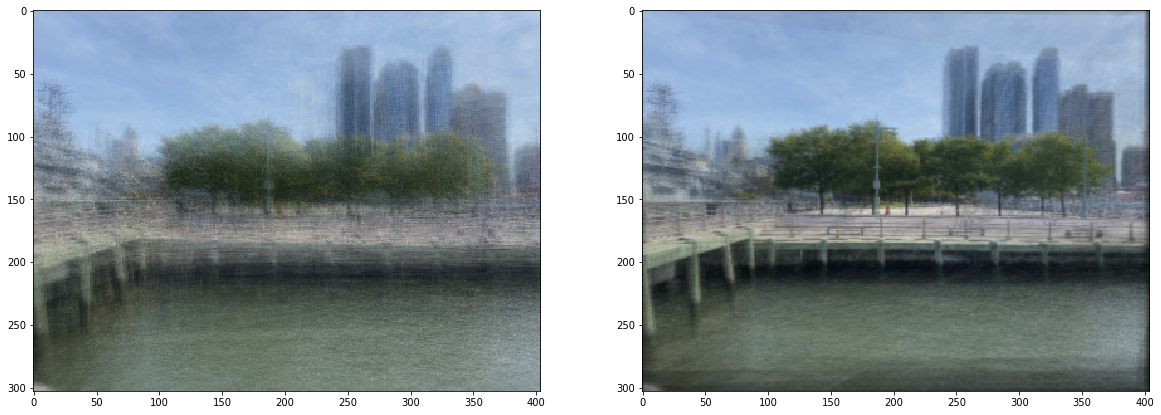

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

z1 = np.array(orig).astype(float).mean(0).astype('uint8')[:, :, ::-1]
z2 = np.array(warped).astype(float).mean(0).astype('uint8')[:, :, ::-1]

ax[0].imshow(z1)
ax[1].imshow(z2)

plt.show()

In [6]:
files[-22]

'images/IMG_0918.jpeg'

In [7]:
# final output file
FPS = 3
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter('./autumn.mp4', fourcc, float(FPS), (2*w, h))
for i, z in zip(orig, warped):
    video.write(np.concatenate((i, z), axis=1))
video.release()